In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import configparser

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
import tqdm
from sklearn.preprocessing import MinMaxScaler

In [3]:
from utils.dataset import Detrender, SlowEarthquakeDataset, create_sequences
from utils.eval import record_metrics
from utils.nn_io import load_model, save_model

In [4]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
columns = {}
dataset = SlowEarthquakeDataset([f"cascadia_{i}_seg" for i in range(1, 6 + 1)])
dataset.load()

for i in range(1, 6 + 1):
    ds_exp = dataset[f"cascadia_{i}_seg"]
    X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]
    columns[f"seg_{i}_avg"] = X.reshape(-1)

ts_data = pd.DataFrame(columns) / 1e8
ts_data.head()

,seg_1_avg,seg_2_avg,seg_3_avg,seg_4_avg,seg_5_avg,seg_6_avg
0,1.510314,0.780134,0.064875,0.114083,-0.051013,0.016110
1,1.256806,0.970059,0.080977,0.070528,-0.012019,0.016997
2,1.074901,0.710642,0.145387,0.138937,0.118613,0.097997
3,1.447256,0.836337,0.173580,0.191626,0.116387,0.104032
4,1.787377,0.846635,0.164064,0.245032,0.144225,0.092539


In [6]:
config = configparser.ConfigParser()
config.read("../config.ini")

lookback = config.getint("ts_forecasting", "lookback")
forecast = config.getint("ts_forecasting", "forecast")
windows = config.getint("ts_forecasting", "windows")

X, y = create_sequences(ts_data.values, lookback, forecast)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

using device: cuda


In [7]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

test_size = windows * forecast
excess = X[:-test_size].shape[0] - forecast * (
    X[:-test_size].shape[0] // forecast
)

X_test, y_test = X[-test_size:], y[-test_size:]
X_train, y_train = X[excess:-test_size], y[excess:-test_size]

X_train_shape, X_test_shape, y_train_shape, y_test_shape = (
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape,
)

X_train_sc, X_test_sc = scaler_X.fit_transform(
    X_train.reshape(-1, 1)
), scaler_X.transform(X_test.reshape(-1, 1))
y_train_sc, y_test_sc = scaler_y.fit_transform(
    y_train.reshape(-1, 1)
), scaler_y.transform(y_test.reshape(-1, 1))

y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

X_train_sc = (
    torch.from_numpy(X_train_sc.reshape(*X_train_shape)).float().to(device)
)
y_train_sc = (
    torch.from_numpy(y_train_sc.reshape(*y_train_shape)).float().to(device)
)
X_test_sc = (
    torch.from_numpy(X_test_sc.reshape(*X_test_shape)).float().to(device)
)
y_test_sc = (
    torch.from_numpy(y_test_sc.reshape(*y_test_shape)).float().to(device)
)

loader = data.DataLoader(
    data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=64
)

In [8]:
import torch
import torch.nn as nn


class Conv2DLSTMModel(nn.Module):
    def __init__(self, n_variates, input_steps, output_steps, hidden_size):
        super(Conv2DLSTMModel, self).__init__()

        self.n_variates = n_variates
        self.input_steps = input_steps
        self.output_steps = output_steps
        self.hidden_size = hidden_size

        self.conv2d = nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=(3, 3), padding=(1, 1)
        )
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(
            input_size=64 * n_variates,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.dense = nn.Linear(hidden_size, output_steps * n_variates)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)

        batch_size = x.size(0)

        x = x.view(batch_size, self.input_steps, -1)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        _, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn.squeeze(0)
        output = self.dense(hn)
        output = output.view(batch_size, self.output_steps, self.n_variates)

        return output


hidden_size = 128
n_variates = len(ts_data.columns)
input_steps = lookback
output_steps = forecast

model = Conv2DLSTMModel(
    n_variates=n_variates,
    input_steps=input_steps,
    output_steps=output_steps,
    hidden_size=hidden_size,
)
model = model.to(device)

In [9]:
learning_rate = 1e-3
num_epochs = int(50)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pbar = tqdm.tqdm(range(num_epochs))

for epoch in pbar:

    model.train()
    for X_batch, y_batch in loader:
        outputs = model(X_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        y_pred = model(X_train_sc.unsqueeze(1))
        y_pred = torch.Tensor(
            scaler_y.inverse_transform(y_pred.cpu().reshape(-1, 1))
        )
        y_pred = y_pred.reshape(*y_train_shape)
        train_rmse = np.sqrt(criterion(y_pred, y_train))

        y_pred = model(X_test_sc.unsqueeze(1))
        y_pred = torch.Tensor(
            scaler_y.inverse_transform(y_pred.cpu().reshape(-1, 1))
        )
        y_pred = y_pred.reshape(*y_test_shape)
        test_rmse = np.sqrt(criterion(y_pred, y_test))

    pbar.set_description(
        f"Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
    )

Epoch [50/50], Train RMSE: 0.0768, Test RMSE: 0.1009: 100%|█████████████████| 50/50 [00:15<00:00,  3.20it/s]


In [10]:
from sklearn.metrics import r2_score

with torch.no_grad():
    y_pred = model(X_test_sc.unsqueeze(1))
    y_pred = torch.Tensor(
        scaler_y.inverse_transform(y_pred.cpu().reshape(-1, 1))
    )
    y_pred = y_pred.reshape(*y_test_shape)
    test_rmse = np.sqrt(criterion(y_pred, y_test))
    test_r2 = r2_score(y_test.reshape(-1, 1), y_pred.reshape(-1, 1))
    print(f"Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")

Test RMSE: 0.1009, Test R^2: 0.9543


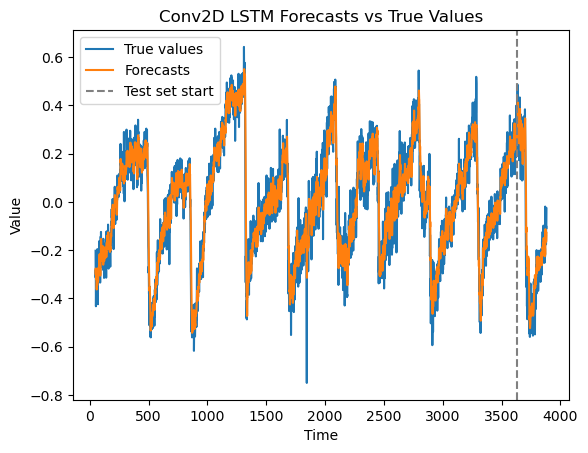

In [11]:
ith_segment = 1

with torch.no_grad():
    train_outputs = scaler_y.inverse_transform(
        model(X_train_sc.unsqueeze(1)).cpu().numpy().reshape(-1, 1)
    ).reshape(*y_train_shape)[:, :, ith_segment]
    test_outputs = y_pred[:, :, ith_segment]

train_outputs = np.array(
    [train_outputs[idx] for idx in range(0, len(train_outputs), forecast)]
).reshape(-1, 1)

test_outputs = np.array(
    [test_outputs[idx] for idx in range(0, len(test_outputs), forecast)]
).reshape(-1, 1)

all_outputs = np.concatenate((train_outputs, test_outputs))

test_start_index = len(ts_data) - len(y_test) - lookback

plt.plot(
    range(lookback, lookback + len(all_outputs)),
    np.concatenate((y_train[:, 0, ith_segment], y_test[:, 0, ith_segment])),
    label="True values",
)

plt.plot(
    range(lookback, lookback + len(all_outputs)),
    all_outputs,
    label="Forecasts",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Conv2D LSTM Forecasts vs True Values")
plt.show()

In [12]:
y_test_skip = np.array(
    [
        y_test[idx, :, ith_segment]
        for idx in range(0, len(test_outputs), forecast)
    ]
).reshape(-1, 1)

y_pred_skip = test_outputs

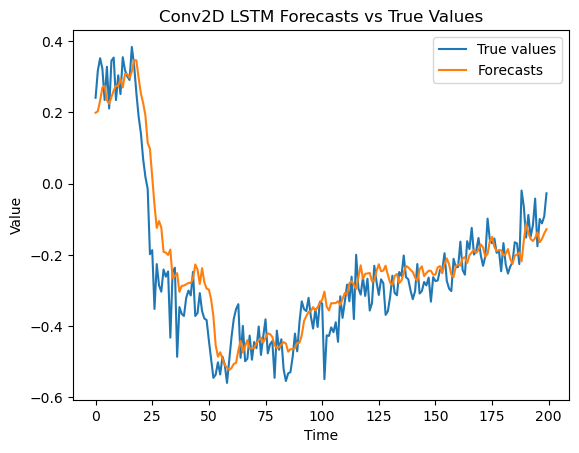

In [13]:
plt.plot(y_test_skip, label="True values")
plt.plot(y_pred_skip, label="Forecasts")

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Conv2D LSTM Forecasts vs True Values")
plt.show()

In [14]:
model_dir = save_model(
    model,
    y_test_skip,
    y_pred_skip,
    range(lookback, lookback + len(all_outputs)),
    model_name="cascadia_1to6",
)

model and data [+ params] saved to /gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/results/p341cam_cascadia_1to6_2024-02-17T15:58:34_torch


In [15]:
model, data, params = load_model(model, model_dir)

model and data [+ params] loaded from /gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/results/p341cam_cascadia_1to6_2024-02-17T15:58:34_torch


In [16]:
record_metrics(model, data, "cascadia_1to6", model_dir)

[1] Thanks for submitting your model to the leaderboard 🍰
[2] ../leaderboard_cascadia_1to6.csv has been updated and sorted by r2_score 🍾
[3] Congratulations! you are rank 1 out of 1 🥂
+-----------+-------------------------------------------------------------------------------------------------------------------+
| user      | p341cam                                                                                                           |
| r2        | 0.8641666488370416                                                                                                |
| mae       | 0.06092200428247452                                                                                               |
| rmse      | 0.08109492808580399                                                                                               |
| exp_type  | cascadia_1to6                                                                                                     |
| model_dir | /gws/nopw/j04/ai4er/us